In [2]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib 
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [3]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [4]:

animals = ['PV_62','PV_126','PV_57']
block_lists = [[23,24,26,38],[7,8,9,10,11,12],[7,8,9,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [5]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax 
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [6]:
# from here is degree conversion:

In [7]:

# read Tali's file:
    

def append_angle_data(eye_df, new_df):
    """
    Appends the kinematics columns (phi and theta) from new_df to eye_df.
    The function renames 'phi' to 'k_phi' and 'theta' to 'k_theta', then merges
    on the shared 'OE_timestamp' column.
    
    Parameters:
    - eye_df: pandas DataFrame containing the eye tracking data.
    - new_df: pandas DataFrame containing the new kinematics data with columns
              'phi' and 'theta' along with 'OE_timestamp' (and possibly others).
    
    Returns:
    - merged_df: pandas DataFrame resulting from merging the new kinematics data
                 into eye_df.
    """
    # Select the necessary columns and rename them
    angle_data = new_df[['OE_timestamp', 'phi', 'theta']].rename(
        columns={'phi': 'k_phi', 'theta': 'k_theta'}
    )
    
    # Merge on OE_timestamp using a left join to preserve all rows in eye_df
    merged_df = pd.merge(eye_df, angle_data, on='OE_timestamp', how='left')
    
    return merged_df
for block in block_collection:
    print(block)
    try:
        left_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('left_kerr_angles_current.csv' in str(i)) ][0])
        right_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('right_kerr_angles_current.csv' in str(i)) ][0])
    except IndexError:
        print(f'{block} has a problem')
    block.left_eye_data = append_angle_data(block.left_eye_data,left_angles)
    block.right_eye_data = append_angle_data(block.right_eye_data,right_angles)

    

PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [8]:
import numpy as np
import pandas as pd

def create_saccade_events_with_direction_segmentation_robust(
    eye_data_df,
    speed_threshold,                # angular speed threshold in degrees/frame
    directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2,
    min_net_disp=0.5                # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta) 
         is below a user-specified minimal value.
    
    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.
    
    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()
    
    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"]**2 + df["speed_y"]**2)
    
    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"]**2 + df["angular_speed_theta"]**2)
    
    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold
    
    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    
    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]
    
    saccade_events = []
    
    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind+1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue
        
        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))
        
        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
        
        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i+1], angles[i]) for i in range(len(angles)-1)])
        
        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()
        
        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]
        
        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue
            
            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"])**2 + 
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"])**2)
            
            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue
            
            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]
            
            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib
            
            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()
            
            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)
            
            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values
            
            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })
    
    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)
    
    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    
    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']
    
    return df, saccade_events_df

In [9]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df  = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.R_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.L_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [10]:
# Now make a function to update saccade detection:
import numpy as np
import pandas as pd

def create_saccade_events_with_direction_segmentation_updated(
    eye_data_df,
    speed_threshold,  # angular speed threshold in degrees/frame
    directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2
):
    """
    Detects saccade events using an angular speed threshold (degrees/frame) and
    segments them based on directional shifts computed from the angular (k_phi/k_theta)
    data. This function computes both pixel-based metrics (from center_x/center_y) and
    angular-based metrics (from k_phi/k_theta) for comparison.
    
    Parameters:
      - eye_data_df (pd.DataFrame): Input DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 
            and 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (in degrees/frame) for saccade detection.
      - directional_delta_threshold_deg (float): Threshold (in degrees) for the instantaneous angle change
            that defines a segmentation boundary within a saccade.
      - magnitude_calib (float): Calibration factor to convert pixel-based speeds to millimeters.
            Not applied to the angular data.
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid subsaccade.
      
    Returns:
      - df (pd.DataFrame): The input DataFrame with additional computed columns.
      - saccade_events_df (pd.DataFrame): A DataFrame listing detected and segmented saccade events,
            with both pixel-derived and angular-derived metrics.
    """
    # Make a copy to avoid modifying the original DataFrame
    df = eye_data_df.copy()
    
    ### 1. Compute Frame-to-Frame Differences
    # -- Pixel-based differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"]**2 + df["speed_y"]**2)
    
    # -- Angular-based differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"]**2 + df["angular_speed_theta"]**2)
    
    ### 2. Saccade Detection Based on Angular Speed
    # Flag candidate saccade samples using the angular speed threshold (degrees/frame)
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold
    
    # Determine saccade onsets and offsets (using angular speed based flag)
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # include one frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    
    # Handle possible mismatches in start/end indices
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")
    
    saccade_events = []
    
    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind+1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue
        
        # Compute instantaneous angles for each frame in the saccade.
        # -- Pixel-based instantaneous angle (derived from center_x/center_y differences)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        # -- Angular-based instantaneous angle (derived from k_phi/k_theta differences)
        saccade_df["inst_angle_deg"] = np.degrees(np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))
        
        # Define an inline helper to compute minimal angular difference (in degrees)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
        
        # Compute differences between consecutive instantaneous angular-based angles (handling circularity)
        angles = saccade_df["inst_angle_deg"].values
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i+1], angles[i]) for i in range(len(angles)-1)])
        
        # Identify candidate segmentation boundaries where the absolute difference exceeds the threshold
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()
        
        # Always include the first and last sample as boundaries
        if not candidate_boundaries:
            boundaries = [0, len(saccade_df) - 1]
        else:
            boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]
        
        # Segment the saccade. Overlap boundaries so that the end of one segment is the start of the next.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue
            
            # Timing and sample indices for this subsaccade
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]
            
            # Pixel-based magnitude (sum of speeds) with calibration
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib
            
            # Angular-based magnitude (in degrees, no calibration applied)
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()
            
            # Compute overall saccade angle for the segment:
            # -- Pixel-based overall angle (using center_x and center_y differences)
            initial_pos_pixel = subsaccade.iloc[0][["center_x", "center_y"]]
            final_pos_pixel = subsaccade.iloc[-1][["center_x", "center_y"]]
            overall_angle_pixel = (np.degrees(np.arctan2(
                final_pos_pixel["center_y"] - initial_pos_pixel["center_y"],
                final_pos_pixel["center_x"] - initial_pos_pixel["center_x"]
            )) % 360)
            
            # -- Angular-based overall angle (using k_phi and k_theta differences)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)
            
            # Speed profiles for the segment
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values
            
            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "overall_angle_pixel": overall_angle_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle['k_theta'],
                "theta_end_pos": final_pos_angle['k_theta'],
                "phi_init_pos": initial_pos_angle['k_phi'],
                "phi_end_pos": final_pos_angle['k_phi']
            })
    
    # Convert the list of saccade events into a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)
    
    # Optionally remove intermediate columns
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    # calculate delta theta and delta phi
    saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
    saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']
    return df, saccade_events_df



In [11]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_updated(
        block.left_eye_data,
        4,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=block.R_pix_size,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_updated(
        block.right_eye_data,
        4,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=block.L_pix_size,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
Detected unmatched final saccade start index. Truncating last saccade start index.
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [12]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\P

In [13]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [14]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [15]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


114it [00:00, 6958.87it/s]
257it [00:00, 9091.67it/s]
242it [00:00, 7559.89it/s]
322it [00:00, 10536.40it/s]

495 566
112 194
260 379



1170it [00:00, 7006.95it/s]

311 364



205it [00:00, 8788.51it/s]
115it [00:00, 8473.04it/s]
123it [00:00, 7481.36it/s]
0it [00:00, ?it/s]

609 1207
182 250
127 154
139 200


734it [00:00, 7056.42it/s]
61it [00:00, 8008.15it/s]
474it [00:00, 8243.26it/s]
0it [00:00, ?it/s]

519 895
40 61
1535 1699


401it [00:00, 7586.96it/s]
460it [00:00, 8635.93it/s]
0it [00:00, ?it/s]

541 720
547 696


1066it [00:00, 5508.50it/s]
630it [00:00, 7797.46it/s]
0it [00:00, ?it/s]

732 1226
258 512


870it [00:00, 6738.72it/s]

1219 1676


In [16]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [17]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [18]:
def add_time_to_peak_velocity(df, sampling_interval_ms):
    """
    Adds a 'time_to_peak_v' column to the dataframe, representing the time (in ms) 
    to reach the peak velocity in the 'speed_profile' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'speed_profile' column with lists of velocities.
    - sampling_interval_ms (float): Sampling interval in milliseconds.

    Returns:
    - pd.DataFrame: Modified DataFrame with a new 'time_to_peak_v' column.
    """
    def compute_time_to_peak(speed_profile):
        if speed_profile is None or len(speed_profile) == 0:  # Explicit check for empty or None
            return np.nan
        peak_index = np.argmax(speed_profile)  # Index of maximum speed
        return peak_index * sampling_interval_ms

    # Apply the computation to each row
    df['time_to_peak_v'] = df['speed_profile_angular'].apply(compute_time_to_peak)
    return df

all_saccade_collection = add_time_to_peak_velocity(all_saccade_collection,17)
synced_saccade_collection = add_time_to_peak_velocity(synced_saccade_collection,17)
non_synced_saccade_collection = add_time_to_peak_velocity(non_synced_saccade_collection,17)
saccade_collection = add_time_to_peak_velocity(saccade_collection,17)

Value = 17, count = 2908
Value = 34, count = 674
Value = 51, count = 31


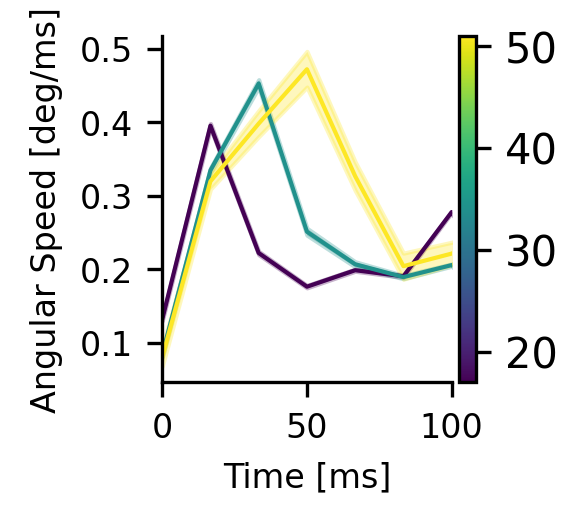

In [25]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde, t
from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

def plot_speed_profiles_with_export_angular(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None, export_path=None, 
    fig_size=(2.5,1.7), set_xlim=None
):
    """
    Plots average angular speed profiles grouped by unique time-to-peak values, up to a ceiling value.
    Angular speed profiles are taken from the 'speed_profile_angular' column, which is assumed to be in deg/frame.
    They are converted to deg/ms by dividing by the frame duration (1000/sampling_rate).
    
    Parameters:
      - saccade_collection: DataFrame containing angular speed profiles (in 'speed_profile_angular') and 
                            time-to-peak values in 'time_to_peak_v'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - floor: Minimum time-to-peak value to include (optional).
      - ceiling: Maximum time-to-peak value to include (optional).
      - export_path: Directory path to export the plot and data (optional).
      - fig_size: Figure size (width, height).
      - set_xlim: Optional x-axis limits.
    """
    # Filter unique time-to-peak values and apply ceiling/floor if provided
    unique_time_to_peak_values = np.unique(saccade_collection['time_to_peak_v'].dropna().astype(int))
    if ceiling is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values <= ceiling]
    if floor is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= floor]
    unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= 0]
    
    # Prepare the figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=unique_time_to_peak_values.min(), vmax=unique_time_to_peak_values.max())
    
    # Calculate frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate  # e.g., ~16.67 ms at 60 Hz   

    # Iterate over each unique time-to-peak value
    for idx, time_to_peak in enumerate(unique_time_to_peak_values):
        # Filter the angular speed profiles for the current time-to-peak value.
        # Note: We now use the 'speed_profile_angular' column.
        profiles = saccade_collection.loc[
            saccade_collection['time_to_peak_v'] == time_to_peak,
            'speed_profile_angular'
        ].dropna().values
        
        if len(profiles) == 0:
            continue

        # Convert each speed profile from deg/frame to deg/ms
        converted_profiles = []
        for profile in profiles:
            # Ensure profile is a NumPy array
            profile = np.array(profile)
            # Convert: deg/frame divided by (ms/frame) gives deg/ms.
            converted_profiles.append(profile / frame_duration)
        
        # Align the converted profiles to the same length
        max_length = max(len(p) for p in converted_profiles)
        aligned_profiles = np.full((len(converted_profiles), max_length), np.nan)
        for i, profile in enumerate(converted_profiles):
            aligned_profiles[i, :len(profile)] = profile

        # Compute average profile and standard error
        avg_profile = np.nanmean(aligned_profiles, axis=0)
        std_error = np.nanstd(aligned_profiles, axis=0) / np.sqrt(len(converted_profiles))

        # Define time points (in ms) for the profile based on sampling rate
        time_points = np.arange(0, len(avg_profile) * frame_duration, frame_duration)

        # Plot the average speed profile with its error region
        ax.plot(time_points, avg_profile, color=cmap(norm(time_to_peak)), lw=1)
        ax.fill_between(time_points, avg_profile - std_error, avg_profile + std_error,
                        color=cmap(norm(time_to_peak)), alpha=0.3)
    
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    
    # Customize the plot labels and appearance
    ax.set_xlabel('Time [ms]', fontsize=8)
    ax.set_ylabel('Angular Speed [deg/ms]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a colorbar for time-to-peak values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    # Uncomment the following line if you wish to add a label to the colorbar:
    # cbar.set_label('Time-to-Peak [ms]', fontsize=8)
    
    # Print counts for debugging
    for value in unique_time_to_peak_values:
        count = len(saccade_collection.query('time_to_peak_v == @value'))
        print(f'Value = {value}, count = {count}')
    
    # Export the figure and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"angular_speed_profiles_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "angular_speed_profiles.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_126"'), sampling_rate=60, floor=1, ceiling=17*3, export_path=None, fig_size=(1.5,1.5), set_xlim=(0,100))

Value = 17, count = 1431
Value = 34, count = 330
Value = 51, count = 9


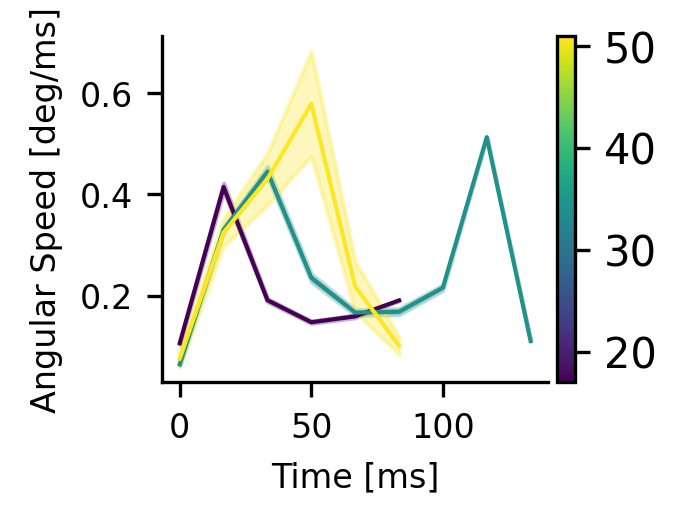

In [20]:
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_62"'), sampling_rate=60, floor=1, ceiling=18*3, export_path=None, fig_size=(2,1.5), set_xlim=None)

Value = 17, count = 2908
Value = 34, count = 674
Value = 51, count = 31


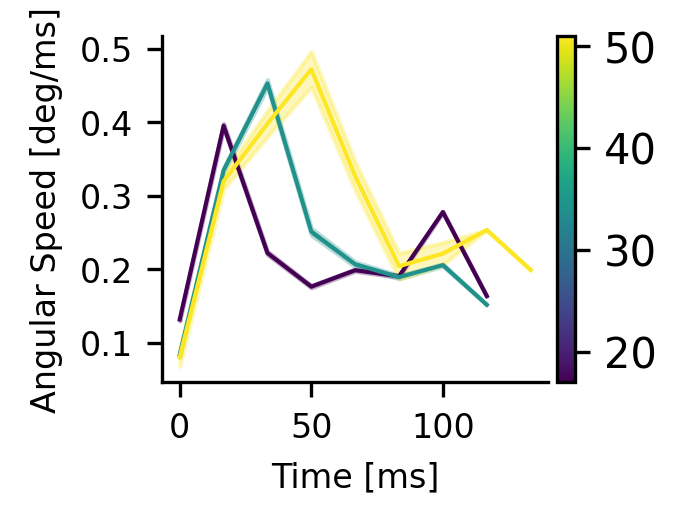

In [21]:
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_126"'), sampling_rate=60, floor=1, ceiling=18*3, export_path=None, fig_size=(2,1.5), set_xlim=None)